# Hospital readmission prediction for diabetes patients
By Dr. David Wasserman

**Work in progress**

## Analysis goal:
Given the data from a hospital visit, predict whether or not the patient will be readmitted within 30 days. I will train a classifier on a subset of the dataset, and test it on an unseen portion of the dataset, with the goal of achieving a high area under curve (AUC) metric.

**Note**: medical practice has changed since 2008, so the resulting model should not be expected to work well with current data. It is intended to shows the skills I would use if I was working with current data.

# Dataset citation

Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). Diabetes 130-US Hospitals for Years 1999-2008 [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.

As of 12 Sept 2025, https://doi.org/10.24432/C5230J redirects to https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008 . File diabetes+130-us+hospitals+for+years+1999-2008.zip retrieved from this site on 12 Sept 2025 by pressing "Download". Files diabetic_data.csv and IDS_mapping.csv were extracted from this zip file.

# Paper written by the dataset creators:

Strack, B., DeShazo, J. P., Gennings, C., Olmo, J. L., Ventura, S., Cios, K. J., & Clore, J. N. (2014). Impact of HbA1c measurement on hospital readmission rates: analysis of 70,000 clinical database patient records. BioMed research international, 2014(1), 781670.

I will refer to this paper as the "original paper". I will refer to the work described in this paper as the "original study".

**Use of "we" and "I"**: When I use the word "we", I am imagining that another person 
(for example, you) is sitting next to me looking at this notebook, and I am describing
something that we can both see in the outputs. None of the things that "we" do
affect the results of the analysis. I use "I" when describing the analytical
methods I've chosen.

# 0 Import packages and show versions

In [1]:
import json
import time
from sys import version

import catboost
import joblib
import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import sklearn
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
start_time = time.time()

In [3]:
# Python version
print('Python version: ', version)

Python version:  3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]


In [4]:
print('joblib', joblib.__version__)
print('lightgbm', lgb.__version__)
print('matplotlib', matplotlib.__version__)
print('numpy', np.__version__)
print('optuna', optuna.__version__)
print('pandas', pd.__version__)
print('seaborn', sns.__version__)
print('xgboost', xgb.__version__)
print('catboost', catboost.__version__)
print('scikit-learn', sklearn.__version__)

joblib 1.5.2
lightgbm 4.6.0
matplotlib 3.10.6
numpy 2.0.1
optuna 4.5.0
pandas 2.3.2
seaborn 0.13.2
xgboost 2.0.3
catboost 1.2.8
scikit-learn 1.7.2


# 1. Data load

In [5]:
df = pd.read_csv(
    'diabetic_data.csv',
    na_values='?',
    keep_default_na=False,
    dtype={
        'diag_1': 'object',
        'diag_2': 'object',
        'diag_3': 'object',
        'payer_code': 'object'}
    )
original_df = df.copy()  # save this, because df will be modified
df.shape

(101766, 50)

## 1.1 Replace the numeric codes with text

In [6]:
# Read the codes and their meanings from IDS_mapping.csv
admission_type = pd.read_csv(
    'IDS_mapping.csv',
    index_col=0,
    nrows=8)
discharge_disposition = pd.read_csv(
    'IDS_mapping.csv',
    index_col=0,
    skiprows=10,
    nrows=30)
admission_source = pd.read_csv(
    'IDS_mapping.csv',
    index_col=0,
    skiprows=42)

# Create dicts to make codes to meanings
admission_type_dict = admission_type.description.to_dict()
discharge_disposition_dict = discharge_disposition.description.to_dict()
admission_source_dict = admission_source.description.to_dict()

# Add columns to df that have the meanings of the codes
df['admission_type'] = df.admission_type_id.replace(
    admission_type_dict,
    inplace=False)
df['discharge_disposition'] = df.discharge_disposition_id.replace(
    discharge_disposition_dict,
    inplace=False)
df['admission_source'] = df.admission_source_id.replace(
    admission_source_dict,
    inplace=False)

# Remove the columns that have the codes
df.drop(columns=[
    'admission_type_id',
    'discharge_disposition_id',
    'admission_source_id'],
        inplace=True)

# We should still have the same number of columns
df.shape

(101766, 50)

## 1.2 Separate inputs from output

In [7]:
# The 'readmitted' column is the output. We only care about readmission
# within 30 days
y = (df['readmitted'] == '<30').astype(int)
df = df.drop(columns=['readmitted'])
(df.shape, y.shape)

((101766, 49), (101766,))

# 2. Scoping

## 2.1 Patients who have expired shouldn't be readmitted. Let's check:

In [8]:
# Find all patients whose discharge disposition contains the word 'expired'
expired_df = df[df['discharge_disposition'].str.contains(
    'expired',
    case=False,
    na=False)]
# For each discharge disposition that contains the word 'expired',
# count the number of each value of 'readmitted'
y.loc[expired_df.index].value_counts()

readmitted
0    1652
Name: count, dtype: int64

We see that of 1652 expired patients, none were readmitted. We remove them from the dataset (this was also done in the original study):

In [9]:
df = df[~df['discharge_disposition'].str.contains(
    'expired',
    case=False,
    na=False,
)]
y = y[df.index]
df.shape, y.shape

((100114, 49), (100114,))

## 2.2 Patients who are discharged to hospice are not expected to be readmitted. Let's check:

In [10]:
# Find all patients whose discharge disposition contains the word 'hospice'
hospice_df = df[df['discharge_disposition'].str.contains(
    'hospice',
    case=False,
    na=False)]
# For each discharge disposition that contains the word 'hospice',
# count the number of each value of 'readmitted'
y.loc[hospice_df.index].value_counts()

readmitted
0    728
1     43
Name: count, dtype: int64

Of 771 patients discharged to hospice, 43 were readmitted within 30 days, which is about 6%. This is high enough that it makes sense to predict readmission for these patients. The original study excluded these patients, but I won't. 

# 3. Preventing data leakage
**For some patients, there are multiple rows, and each of these rows is for a different hospital visit.**

There are no dates in the dataset. When we are using the data from a visit to predicting if a patient is readmitted, if the correct answer is yes, that readmission might be another visit that was used to train the classifier. This would be data leakage. To avoid that problem, we use only one visit for each patient. (This was also done in the original study.)

In [11]:
df.drop_duplicates(subset=['patient_nbr'], inplace=True)
y = y[df.index]
df.shape, y.shape

((70439, 49), (70439,))

In [12]:
# Patient number is no longer needed. Encounter ID also isn't needed
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)
df.shape

(70439, 47)

# 4. Separating training data from test set
I will save 5000 samples for testing. It is common to save 20%, but I think 5000 is enough to accurately evaluate the model.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=5000, random_state=0)
[z.shape for z in [X_train, X_test, y_train, y_test]]

[(65439, 47), (5000, 47), (65439,), (5000,)]

In [14]:
# Save data to files
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

# 5 Data dictionary

Let's start by looking at the list of columns:

In [15]:
list(X_train.columns)

['race',
 'gender',
 'age',
 'weight',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'diag_1',
 'diag_2',
 'diag_3',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'admission_type',
 'discharge_disposition',
 'admission_source']

In [16]:
# Some columns aren't self-explanatory. These explanations are based on
# Table 1 of the original paper:
column_explanation = {
    'weight': 'Weight in pounds',
    'medical_specialty': 'Specialty of the admitting physician',
    'time_in_hospital': 'in days',
    'num_lab_procedures': 'during the encounter',
    'num_procedures': 'during the encounter, not counting lab tests',
    'num_medications': 'number of different medications during the encounter',
    'number_outpatient': ('Number of outpatient visits of the patient in the '
                          + 'year preceding the encounter'),
    'number_emergency': ('Number of emergency visits of the patient in the '
                         + 'year preceding the encounter'),
    'number_inpatient': ('Number of inpatient visits of the patient in the '
                         + 'year preceding the encounter'),
    'diag_1': 'Primary diagnosis ICD-9 code',
    'diag_2': 'Secondary diagnosis ICD-9 code',
    'diag_3': 'Additional secondary diagnosis ICD-9 code',
    'max_glu_serum': ('Indicates the range of the serum glucose result or if '
                      + 'the test was not taken. Values: “>200”, “>300”, '
                      + '“normal”, and “none” if not measured'),
    'A1Cresult': ('Indicates the range of the result or if the test was not '
                  + 'taken. Values: “>8” if the result '
                  + 'was greater than 8%, “>7” if the result was greater '
                  + 'than 7% but less than 8%, “normal” '
                  + 'if the result was less than 7%, and “none” if not '
                  + 'measured. Includes results from up to '
                  + 'three months before admission'),
    'change': ('Indicates if there was a change in diabetic medications '
               + '(either dosage or generic name). Values: “change” and '
               + '“no change”'),
    'diabetesMed': 'Indicates if there was any diabetic medication prescribed'
}

23 consecutive columns names are the names of specific medications. [See note 1](#Footnotes)

In [17]:
specific_med_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'sitagliptin', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]
for column in specific_med_columns:
    column_explanation[column] = (
        f'Indicates whether {column} was prescribed '
        + 'or there was a change in the dosage. '
        + 'Values: “up” if the dosage was increased '
        + 'during the encounter, “down” if the '
        + 'dosage was decreased, “steady” if the dosage did not change, and '
        + '“no” if the drug was not prescribed')

I'll define a function that I find useful for describing a column:

In [18]:
def print_column_info(column: str) -> None:
    '''
    Print some useful information about a column of X_train

    Args:
        column: string, name of a column of X_train
    '''
    if column in column_explanation:
        print(column_explanation[column])
    print('type:', X_train[column].dtype)
    print('values present:', (~X_train[column].isna()).sum(),
          ', values missing:', X_train[column].isna().sum())
    nunique = X_train[column].nunique()
    print('unique:', nunique)
    if nunique <= 20:
        print('Counts')
        print(X_train[column].value_counts())
    else:
        print(X_train[column].describe())
        print('Counts of 20 most common values')
        print(X_train[column].value_counts().head(20))
        print('Counts of counts of other values')
        print(X_train[column]
              .value_counts()
              .tail(nunique - 20)
              .value_counts()
              .sort_index(ascending=False))

# 6. Testing if the data has expected properties

**Except where indicated, these tests are done only on X_train.** Let's start by looking at a few patients:

In [19]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_row', 30)
X_train.head(10)

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_type,discharge_disposition,admission_source
24248,Caucasian,Male,[70-80),NaN,4,NaN,NaN,57,0,17,0,0,0,250.81,255,496,8,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,Emergency,Discharged/transferred to SNF,Emergency Room
93404,Caucasian,Female,[70-80),NaN,6,MC,Emergency/Trauma,79,0,24,0,0,0,410,435,446,9,None,>7,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,Emergency,Discharged/transferred to another rehab fac in...,Emergency Room
98028,AfricanAmerican,Male,[80-90),NaN,7,NaN,NaN,83,0,20,0,0,0,584,404,599,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Emergency,Discharged/transferred to another type of inpa...,Emergency Room
31977,Caucasian,Male,[50-60),NaN,4,UN,Surgery-Cardiovascular/Thoracic,51,3,22,0,0,0,414,413,401,5,None,>8,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,Urgent,Discharged to home,Physician Referral
77979,AfricanAmerican,Male,[40-50),NaN,2,CP,NaN,64,0,13,0,0,0,276,250.23,280,7,None,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,Emergency,Discharged to home,Emergency Room
54947,Caucasian,Male,[60-70),NaN,4,HM,NaN,52,2,18,0,0,0,185,250,401,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Elective,Discharged to home,Physician Referral
86972,AfricanAmerican,Male,[40-50),NaN,1,CP,NaN,51,0,10,0,0,0,250.02,283,401,6,None,>7,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,Elective,Discharged to home,Physician Referral
23271,AfricanAmerican,Female,[30-40),NaN,2,NaN,NaN,55,0,10,0,0,0,786,250,401,5,None,>8,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,Emergency,Discharged to home,Emergency Room
40707,Caucasian,Female,[70-80),NaN,1,MC,InternalMedicine,43,0,5,0,0,0,593,276,780,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Emergency,Discharged to home,Emergency Room
77187,Caucasian,Female,[70-80),NaN,5,MC,NaN,62,1,19,0,0,0,38,599,584,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,Elective,Hospice / medical facility,Physician Referral


## 6.1. Do column names match those in the original paper?

Table 1 of the paper lists the columns, and gives an explanation for each column.

In [20]:
X_train.columns

Index(['race', 'gender', 'age', 'weight', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type',
       'discharge_disposition', 'admission_source'],
      dtype='object')

There is one error: "citoglipton" isn't the name of a medication. The paper has
the correct name, "sitagliptin". 

Also, most of the capital letters have been removed, most of the spaces have been replaced with underscores, and some words have been abbreviated.

In [21]:
X_train.rename(columns={'citoglipton': 'sitagliptin'}, inplace=True)
X_test.rename(columns={'citoglipton': 'sitagliptin'}, inplace=True)

## 6.2 This is a diabetes dataset. What percentage of patients have a diabetes code?
ICD-9 is an international diagnosis coding system created by the World Health Organization (WHO). In this system, 250 is the code for diabetes mellitus. In the United States, ICD-9-CM forms more specific diagnosis codes by adding a decimal point and one or two digits. For example, 250.0 is Diabetes mellitus without mention of complication. 250.02 is Diabetes mellitus without mention of complication, type II or unspecified type, uncontrolled.

There is also an ICD-9 code for secondary diabetes, 249.

In [22]:
percentage_250 = (
    X_train['diag_1'].str.startswith('250')
    | X_train['diag_2'].str.startswith('250')
    | X_train['diag_3'].str.startswith('250')
    ).mean()*100
percentage_249 = (
    X_train['diag_1'].str.startswith('249')
    | X_train['diag_2'].str.startswith('249')
    | X_train['diag_3'].str.startswith('249')
    ).mean()*100
print((f'{percentage_250:.2f}%', f'{percentage_249:.5f}%'))

('39.20%', '0.00000%')


The paper says that all of these patients had diabetes. However, the dataset has only three columns to record diagnoses, even though most of the patients had more than three diagnoses:  

In [23]:
print(X_train['number_diagnoses'].mean())

7.233377649413958


For most patients, the diagnosis columns don't include all the diagnoses, so it makes sense that only 39% of the patients have diabetes in one of the three diagnosis columns. 

## 6.3 Does `number_diagnoses` have a plausible distribution:
Let's take a closer look at the `number_diagnoses` column:

In [24]:
print('missing values:', X_train.number_diagnoses.isna().sum())
X_train.number_diagnoses.value_counts().sort_index()

missing values: 0


number_diagnoses
1       175
2       817
3      2185
4      4118
5      8262
6      7054
7      7003
8      6893
9     28866
10        9
11        5
12        6
13        7
14        5
15        6
16       28
Name: count, dtype: int64

This is a strange distribution. 4 through 9 are all common values, with 9 by far the most common, while only about 0.1% of the values are greater than 9. The most likely explanation is that much of this data came from systems that could not record more than 9 diagnoses. There were probably more than 20,000 patients who could have had 10, 11, 12, or more diagnoses, but instead got exactly 9 because that was the limit. Similarly, 16 occurs 28 times, which is more than 12, 13, 14, and 15 combined. It seems likely that at least 20 out of these 28 could have had more than 16 diagnoses, but the system could only record 16.

The original paper indicates that all of this data came from organizations using the Cerner Electronic Health Record (EHR) System. However, EHRs were not commonly used in 1999, so much of this data was original captured in paper-based systems and later copied into Cerner. This could explain why there could be more than one diagnosis limit.

## 6.4 Are `diag_1`, `diag_2`, and `diag_3` consistent with `number_diagnoses`?
We'll add a column `diag_filled` showing whether `diag_1`, `diag_2`, and `diag_3` are filled or blank.

In [25]:
code_columns_list = ['diag_1', 'diag_2', 'diag_3']

In [26]:
def fill_pattern(row: pd.Series) -> str:
    '''
    Indicate which of the ICD-9 columns are filled for a row of X_train

    Args:
        row: pandas Series; a row of X_train
    Returns:
        string
    '''
    filled = ['Blank' if row.isna().loc[col] else 'Filled'
              for col in code_columns_list]
    return ', '.join(filled)

In [27]:
X_train['diag_filled'] = X_train.apply(fill_pattern, axis=1)

In [28]:
X_train['diag_filled'].value_counts()

diag_filled
Filled, Filled, Filled    64261
Filled, Filled, Blank       902
Filled, Blank, Blank        218
Filled, Blank, Filled        47
Blank, Filled, Filled        10
Blank, Blank, Blank           1
Name: count, dtype: int64

If number_diagnoses is 1, we expect to see "Filled, Blank, Blank".
If number_diagnoses is 2, we expect to see "Filled, Filled, Blank".
If number_diagnoses is 3 or more, we expect to see "Filled, Filled, Filled".
How often does this happen?

In [29]:
X_train[X_train.number_diagnoses == 1].diag_filled.value_counts()

diag_filled
Filled, Blank, Blank    175
Name: count, dtype: int64

In [30]:
X_train[X_train.number_diagnoses == 2].diag_filled.value_counts()

diag_filled
Filled, Filled, Blank    815
Filled, Blank, Blank       2
Name: count, dtype: int64

In [31]:
X_train[X_train.number_diagnoses >= 3].diag_filled.value_counts()

diag_filled
Filled, Filled, Filled    64261
Filled, Filled, Blank        87
Filled, Blank, Filled        47
Filled, Blank, Blank         41
Blank, Filled, Filled        10
Blank, Blank, Blank           1
Name: count, dtype: int64

We find that two patients with `number_diagnoses == 2` are missing the second diagnosis, 
and 186 patients with with `number_diagnoses >= 3` are missing at least one of the three 
diagnoses.
We'll add a column called `diag_consistent` and mark these patients with `False`.

In [32]:
def diag_consistent(row: pd.Series) -> bool:
    '''
    Check if the diagnosis columns are consistent for a row of X_train

    Args:
        row: pandas Series, a row a X_train
    Returns:
        boolean
    '''
    if row.number_diagnoses == 1:
        return row.diag_filled == 'Filled, Blank, Blank'
    if row.number_diagnoses == 2:
        return row.diag_filled == 'Filled, Filled, Blank'
    return row.diag_filled == 'Filled, Filled, Filled'

In [33]:
X_train['diag_consistent'] = X_train.apply(diag_consistent, axis=1)
print(X_train['diag_consistent'].value_counts())
print(X_train[~X_train['diag_consistent']]
      .number_diagnoses
      .value_counts()
      .sort_index())

diag_consistent
True     65251
False      188
Name: count, dtype: int64
number_diagnoses
2     2
3    16
4    26
5    95
6    10
7    11
8    24
9     4
Name: count, dtype: int64


188 patients, about 0.3%, have inconsistent diagnosis data. Some patients with as many as 9 diagnoses 
don't have three diagnosis codes. I prefer to make the training data cleaner by deleting these patients. 
However, when making predictions on the test set, I will include patients with inconsistent diagnosis data.

In [34]:
y_train = y_train[X_train.diag_consistent]
X_train = X_train[X_train.diag_consistent]

In [35]:
# The columns diag_consistent and diag_filled won't be needed again
X_train = X_train.drop(columns=['diag_consistent', 'diag_filled'])
(X_train.shape, y_train.shape)

((65251, 47), (65251,))

## 6.5 Does the same code ever occur in more than one column?

In [36]:
print((X_train.diag_1 == X_train.diag_2).sum())

1196


Yes, about 2% of patients have `diag_2` the same as `diag_1`. Here's the first 10 examples:

In [37]:
examples = (
    X_train[X_train.diag_1.notna() & (X_train.diag_1 == X_train.diag_2)]
).head(10)
examples

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,sitagliptin,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_type,discharge_disposition,admission_source
92418,Caucasian,Male,[70-80),NaN,2,NaN,InternalMedicine,39,0,8,0,0,0,428,428,414,9,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Emergency,Discharged to home,Emergency Room
38634,Caucasian,Female,[40-50),NaN,1,UN,Emergency/Trauma,5,0,3,0,0,0,780,780,787,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Urgent,Discharged to home,Emergency Room
31189,Caucasian,Male,[80-90),NaN,4,MC,NaN,44,0,12,0,0,0,805,805,E885,9,None,None,Up,No,No,No,No,No,No,Up,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,Emergency,Discharged/transferred to another rehab fac in...,Emergency Room
22270,Caucasian,Male,[70-80),NaN,1,NaN,NaN,39,6,11,1,0,0,414,414,250,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Elective,Discharged to home,Physician Referral
90232,Caucasian,Male,[60-70),NaN,2,MC,Radiologist,13,1,14,0,1,1,427,427,427,9,None,None,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,Elective,Discharged to home,Physician Referral
1922,Caucasian,Female,[50-60),NaN,1,NaN,Cardiology,37,5,17,0,0,0,414,414,414,5,None,None,No,No,No,No,No,No,Steady,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,NaN,Discharged to home,NaN
20207,AfricanAmerican,Male,[80-90),NaN,12,NaN,NaN,55,4,12,0,0,0,198,198,788,8,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Emergency,Discharged to home,Emergency Room
10396,AfricanAmerican,Male,[50-60),NaN,5,NaN,NaN,43,2,12,0,0,1,577,577,162,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,Urgent,Discharged to home,Clinic Referral
34225,AfricanAmerican,Female,[10-20),NaN,6,MD,Psychiatry,72,3,8,0,0,0,296,296,305,8,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Urgent,Discharged to home,Emergency Room
57962,Caucasian,Female,[40-50),NaN,8,BC,Emergency/Trauma,50,0,16,1,0,0,682,682,41,9,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,Steady,No,No,No,No,Ch,Yes,Emergency,Discharged to home,Emergency Room


I don't believe it's useful to have the same code twice for one patient, so I'm going to delete the duplicate codes
in `X_train`. This will make it easier to select diagnosis code features.
I won't use `X_test` to select features, so there's no need to delete duplicate codes in `X_test`.

In [38]:
X_train.loc[
    X_train.diag_1.notna() & (X_train.diag_1 == X_train.diag_2),
    'diag_2'] = np.nan
X_train.loc[
    X_train.diag_1.notna() & (X_train.diag_1 == X_train.diag_3),
    'diag_3'] = np.nan
X_train.loc[
    X_train.diag_2.notna() & (X_train.diag_2 == X_train.diag_3),
    'diag_3'] = np.nan

In [39]:
print((X_train.diag_1 == X_train.diag_2).sum())

0


## 6.6 The paper says that `diag_1`, `diag_2`, and `diag_3` are coded as first three digits of ICD9. Is this true?

We start by combining the three ICD-9 code columns into a single series:

In [40]:
all_codes = X_train[code_columns_list].stack()
print(all_codes.shape)
all_codes.head(10)

(190952,)


24248  diag_1    250.81
       diag_2       255
       diag_3       496
93404  diag_1       410
       diag_2       435
       diag_3       446
98028  diag_1       584
       diag_2       404
       diag_3       599
31977  diag_1       414
dtype: object

Already we see a code with more than three digits. Let's make a list of all distinct codes,
and see how long they are:

In [41]:
unique_codes = pd.Series(all_codes.unique())
unique_codes.str.len().value_counts()

3    732
4     77
2     34
6     25
5      9
1      5
Name: count, dtype: int64

Let's examine these codes whose length is not 3:

In [42]:
for length in [1, 2, 4, 5, 6]:
    print(sorted([code for code in unique_codes if len(code) == length]))

['3', '5', '7', '8', '9']
['10', '11', '14', '17', '27', '31', '34', '35', '36', '38', '39', '40', '41', '42', '46', '47', '48', '49', '52', '53', '54', '57', '61', '66', '70', '75', '78', '79', '82', '84', '88', '94', '98', '99']
['E812', 'E813', 'E814', 'E815', 'E816', 'E817', 'E818', 'E819', 'E821', 'E825', 'E826', 'E828', 'E829', 'E849', 'E850', 'E852', 'E853', 'E854', 'E855', 'E858', 'E861', 'E865', 'E870', 'E878', 'E879', 'E880', 'E881', 'E882', 'E883', 'E884', 'E885', 'E886', 'E887', 'E888', 'E890', 'E892', 'E894', 'E900', 'E901', 'E904', 'E905', 'E906', 'E909', 'E912', 'E915', 'E916', 'E917', 'E919', 'E920', 'E922', 'E924', 'E927', 'E928', 'E929', 'E930', 'E931', 'E932', 'E933', 'E934', 'E935', 'E936', 'E937', 'E938', 'E939', 'E941', 'E942', 'E943', 'E944', 'E945', 'E946', 'E947', 'E949', 'E950', 'E956', 'E965', 'E968', 'E980']
['250.1', '250.2', '250.3', '250.4', '250.5', '250.6', '250.7', '250.8', '250.9']
['250.01', '250.02', '250.03', '250.11', '250.12', '250.13', '250.21',

We see that the codes of length 1 and 2 are all numeric. These could be three-digit ICD-9 codes
that are missing their leading zeroes. For example, 003 is the code for Other salmonella infections.
Do any of the codes have leading zeroes?

In [43]:
print(unique_codes.str.startswith('0').sum())

0


No, all the leading zeroes have been omitted from the codes.

The codes of length 4 are all "E" followed by three digits. This identifies them as external cause codes in ICD-9-CM.

As I mentioned earlier, ICD-9 has three-digit codes, and ICD-9-CM creates more specific codes by adding a decimal point and one or two digits. Because this dataset is about diabetes, it makes sense that the creators chose to include fourth and fifth digits of diabetes codes, while removing these digits from other codes. I can't explain why they left in 365.44, the code for Glaucoma associated with systemic syndromes.

Are the three-digit codes all numeric?

In [44]:
unique_codes[unique_codes.str.len() == 3].str.isnumeric().value_counts()

True     685
False     47
Name: count, dtype: int64

No, 47 of the three digits codes are not numeric. Let's look at those:

In [45]:
print(sorted([code for code in unique_codes
              if len(code) == 3 and not code.isnumeric()]))

['V01', 'V02', 'V03', 'V06', 'V07', 'V08', 'V09', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V23', 'V25', 'V26', 'V27', 'V42', 'V43', 'V44', 'V45', 'V46', 'V49', 'V50', 'V51', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V70', 'V71', 'V72', 'V85', 'V86']


All begin with "V". ICD-9 uses V codes to classify factors influencing health status and contact with health services. For example, V01 means Contact with or exposure to communicable diseases.

## 6.7 Is `age` consistent with other columns?

Usually there is no information about age in other columns, but there are a few exceptions:
1. If the admission type is "Newborn", that means this hospital stay began with the patient's birth, so the patient's age at discharge is the duration of the stay. In this dataset the duration of the stay is at most 14 days.
2. Some patients have a discharge disposition of "Neonate discharged to another hospital for neonatal aftercare". A neonate is someone whose age is less than 28 days
3. The admission source values " Extramural Birth" and " Sick Baby" also indicate a patient less than one year old.

Let's look at these patients:

In [46]:
X_train[X_train.admission_type == 'Newborn']

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,sitagliptin,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_type,discharge_disposition,admission_source
2461,AfricanAmerican,Male,[70-80),NaN,5,NaN,NaN,73,1,12,0,0,0,562,428,250.52,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,Newborn,Discharged/transferred to home with home healt...,Transfer from a hospital
80354,Hispanic,Female,[0-10),NaN,2,NaN,Family/GeneralPractice,27,0,2,0,0,0,786,782,E941,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Newborn,Discharged to home,Physician Referral
35877,AfricanAmerican,Male,[60-70),NaN,3,UN,InternalMedicine,66,0,18,0,0,0,276,427,V42,5,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,Newborn,Discharged to home,Extramural Birth
4823,Caucasian,Female,[60-70),NaN,2,NaN,NaN,39,0,7,0,0,0,250.82,707,401,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,Newborn,Discharged/transferred to home with home healt...,Transfer from a hospital
2203,Caucasian,Male,[80-90),NaN,2,NaN,NaN,46,6,14,0,0,0,414,411,401,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,Newborn,Discharged to home,Transfer from a hospital
48711,Caucasian,Female,[70-80),[75-100),4,CP,NaN,37,1,18,3,0,0,715,272,401,9,None,None,No,No,No,No,Steady,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,Newborn,Discharged/transferred to home with home healt...,Physician Referral
2043,Caucasian,Male,[50-60),NaN,2,NaN,NaN,56,2,13,0,0,0,414,411,401,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,Newborn,Discharged to home,Transfer from a hospital
100721,Asian,Male,[80-90),[50-75),3,CM,NaN,51,0,10,0,0,0,491,276,250.8,5,None,>7,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Newborn,Discharged/transferred to home with home healt...,Emergency Room


In [47]:
X_train[X_train.discharge_disposition ==
        'Neonate discharged to another hospital for neonatal aftercare']

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,sitagliptin,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_type,discharge_disposition,admission_source
1983,Caucasian,Male,[50-60),NaN,4,NaN,Surgery-General,41,1,8,0,0,0,715,493,250,3,>200,>8,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NaN,Neonate discharged to another hospital for neo...,Physician Referral
487,Caucasian,Female,[70-80),NaN,9,NaN,NaN,72,0,14,0,0,0,434,428,250.01,5,>200,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NaN,Neonate discharged to another hospital for neo...,Emergency Room
1101,Caucasian,Male,[60-70),NaN,8,NaN,NaN,23,2,11,0,0,2,V57,434,250.6,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NaN,Neonate discharged to another hospital for neo...,Physician Referral
1636,Caucasian,Female,[80-90),NaN,3,NaN,NaN,44,2,19,0,0,0,715,250.02,401,3,Norm,None,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NaN,Neonate discharged to another hospital for neo...,Physician Referral
1027,Hispanic,Female,[70-80),NaN,8,NaN,NaN,67,0,7,0,0,1,434,342,784,5,>200,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NaN,Neonate discharged to another hospital for neo...,Emergency Room
1585,Caucasian,Female,[90-100),NaN,5,NaN,InternalMedicine,77,2,17,0,0,1,820,496,250.02,5,Norm,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NaN,Neonate discharged to another hospital for neo...,Emergency Room


In [48]:
X_train[X_train.admission_source == ' Extramural Birth']

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,sitagliptin,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_type,discharge_disposition,admission_source
83432,AfricanAmerican,Female,[70-80),NaN,3,CM,NaN,66,2,8,0,0,0,427,599,174,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Emergency,Discharged to home,Extramural Birth
35877,AfricanAmerican,Male,[60-70),NaN,3,UN,InternalMedicine,66,0,18,0,0,0,276,427,V42,5,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,Newborn,Discharged to home,Extramural Birth


In [49]:
X_train[X_train.admission_source == ' Sick Baby']

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,sitagliptin,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,admission_type,discharge_disposition,admission_source
97384,Caucasian,Male,[70-80),NaN,3,CM,InternalMedicine,1,3,13,0,0,0,996,E878,401,9,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Urgent,Discharged to home,Sick Baby


No, they are not consistent. Out of 16 patients who should be babies 
(including one who appears twice), all but one is at least
50 years old. I will remove these 15 inconsistent patients from the training data. However,
I will not remove inconsistencies from the test data.

In [50]:
age_inconsistent = (
    ((X_train.admission_type == 'Newborn') & ~(X_train.age == '[0-10)'))
    | (X_train.discharge_disposition ==
       'Neonate discharged to another hospital for neonatal aftercare')
    | (X_train.admission_source == ' Sick Baby')
    | (X_train.admission_source == ' Extramural Birth')
)
print(age_inconsistent.sum())

15


In [51]:
y_train = y_train[~age_inconsistent]
X_train = X_train[~age_inconsistent]
(X_train.shape, y_train.shape)

((65236, 47), (65236,))

## 6.8 Does `weight` have a plausible distribution?

In [52]:
print_column_info('weight')

Weight in pounds
type: object
values present: 2635 , values missing: 62601
unique: 9
Counts
weight
[75-100)     1108
[50-75)       712
[100-125)     524
[125-150)     125
[25-50)        82
[0-25)         43
[150-175)      32
[175-200)       8
>200            1
Name: count, dtype: int64


We see that more than 70% of the values are less than 100.

The original paper says that the weight values are in pounds, but I think they're kilograms. Diabetes is more common in heavy people. It's not plausible that the median weight of diabetes patients is between 75 and 100 pounds. It is plausible that the median is between 75 kg (165 pounds) and 100 kg (220 pounds).

In [53]:
column_explanation['weight'] = 'Weight in kilograms'

## 6.9 Do categorical columns have any unexpected values?

For many of the columns, the paper lists all values that should be in those columns.

For the 23 specific medication columns, the values should be "No", "Steady", "Up", and "Down". 
Let's check to see if there are any others:

In [54]:
specific_med_values = ['No', 'Steady', 'Up', 'Down']
for col in specific_med_columns:
    for value in X_train[col].unique():
        if value not in specific_med_values:
            print(X_train[col].value_counts())

No output means no unexpected values.

`admission_type`, `discharge_disposition`, and `admission_source` were initially 
numeric. We found these numbers in the first column of IDS_mapping.csv, and replaced them with the corresponding strings in the second column. If these 
columns had any values not listed in the first column of IDS_mapping.csv, those values would still
be there. Let's check:

In [55]:
for col in ['admission_type', 'discharge_disposition', 'admission_source']:
    print(col, list(X_train[col].unique()))

admission_type ['Emergency', 'Urgent', 'Elective', nan, 'Not Mapped', 'Not Available', 'Newborn', 'Trauma Center']
discharge_disposition ['Discharged/transferred to SNF', 'Discharged/transferred to another rehab fac including rehab units of a hospital .', 'Discharged/transferred to another type of inpatient care institution', 'Discharged to home', 'Hospice / medical facility', 'Discharged/transferred to home with home health service', nan, 'Discharged/transferred to ICF', 'Discharged/transferred to another short term hospital', 'Left AMA', 'Discharged/transferred to a long term care hospital.', 'Not Mapped', 'Discharged/transferred within this institution to Medicare approved swing bed', 'Hospice / home', 'Discharged/transferred to home under care of Home IV provider', 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital', 'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.', 'Dis

All of these values are expected. Now we check the rest of the columns with specified values:

In [56]:
for col in [
    'race',
    'gender',
    'age',
    'max_glu_serum',
    'A1Cresult',
    'change',
    'diabetesMed'
]:
    print(col, list(X_train[col].unique()))

race ['Caucasian', 'AfricanAmerican', nan, 'Other', 'Hispanic', 'Asian']
gender ['Male', 'Female', 'Unknown/Invalid']
age ['[70-80)', '[80-90)', '[50-60)', '[40-50)', '[60-70)', '[30-40)', '[20-30)', '[0-10)', '[90-100)', '[10-20)']
max_glu_serum ['None', '>300', 'Norm', '>200']
A1Cresult ['>8', '>7', 'None', 'Norm']
change ['Ch', 'No']
diabetesMed ['Yes', 'No']


This is good; all of these values are mentioned in the original paper.

## 6.10 Do numeric columns have any unexpected values?

The paper describes 11 of the columns as numeric: Encounter ID, Patient number, Weight, Time in hospital, Number of lab procedures, Number of procedures, Number of medications, Number of outpatient visits, Number of emergency visits, Number of inpatient visits, and Number of diagnoses. We dropped the first two, and we've already examined `weight` and `number_diagnoses`. Let's look at the other seven:

In [57]:
current_columns = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient'
]
for col in current_columns:
    print((col, X_train[col].dtype, column_explanation.get(col, '')))

X_train[current_columns].describe()

('time_in_hospital', dtype('int64'), 'in days')
('num_lab_procedures', dtype('int64'), 'during the encounter')
('num_procedures', dtype('int64'), 'during the encounter, not counting lab tests')
('num_medications', dtype('int64'), 'number of different medications during the encounter')
('number_outpatient', dtype('int64'), 'Number of outpatient visits of the patient in the year preceding the encounter')
('number_emergency', dtype('int64'), 'Number of emergency visits of the patient in the year preceding the encounter')
('number_inpatient', dtype('int64'), 'Number of inpatient visits of the patient in the year preceding the encounter')


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient
count,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000,65236.000000
mean,4.285870,42.932215,1.424428,15.671270,0.281271,0.104727,0.178260
std,2.942847,19.919108,1.756096,8.269405,1.063364,0.516435,0.608315
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000
50%,3.000000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000


This is good. All of the values are integers. Observe
1. `1 <= time_in_hospital <= 14`
2. `1 <= num_lab_procedures`
3. `1 <= num_medications`
  
Section 2.2 of the original paper specifies all of these conditions as criteria for inclusion in the dataset. `num_inpatient == 0` is allowed because the current hospitalization is not counted.

The paper also specifies five "Nominal" columns in which the values are integer identifiers.
In three of these columns, we have already replaced the integers with the strings in IDS_mapping.csv,
but the other two, `payer_code` and `medical_specialty`, are not mentioned in IDS_mapping.csv.

In [58]:
X_train[['payer_code', 'medical_specialty']].dtypes

payer_code           object
medical_specialty    object
dtype: object

The paper is incorrect; these columns don't contain integers. Let's look at their values:

In [59]:
print(X_train['payer_code'].unique())
print(X_train['medical_specialty'].unique())

[nan 'MC' 'UN' 'CP' 'HM' 'BC' 'OG' 'MD' 'SP' 'CM' 'WC' 'OT' 'PO' 'SI' 'DM'
 'CH' 'MP' 'FR']
[nan 'Emergency/Trauma' 'Surgery-Cardiovascular/Thoracic'
 'InternalMedicine' 'Radiology' 'Orthopedics' 'Cardiology' 'Radiologist'
 'Family/GeneralPractice' 'Surgery-General' 'Orthopedics-Reconstructive'
 'Psychology' 'Surgery-Thoracic' 'Urology' 'Nephrology'
 'Hematology/Oncology' 'ObstetricsandGynecology' 'Psychiatry'
 'Pulmonology' 'Endocrinology' 'Gastroenterology' 'Surgery-Vascular'
 'Surgery-Neuro' 'InfectiousDiseases' 'Pediatrics-Endocrinology'
 'PhysicalMedicineandRehabilitation' 'Oncology' 'Pediatrics' 'Neurology'
 'Gynecology' 'Podiatry' 'Endocrinology-Metabolism' 'Rheumatology'
 'Surgery-Cardiovascular' 'SurgicalSpecialty' 'Otolaryngology'
 'Hospitalist' 'Surgery-Plastic' 'Surgery-Pediatric'
 'Surgery-Maxillofacial' 'Osteopath' 'Pediatrics-CriticalCare' 'Surgeon'
 'Ophthalmology' 'Anesthesiology-Pediatric' 'AllergyandImmunology'
 'Anesthesiology' 'Cardiology-Pediatric' 'Obstetrics' 'H

## 6.11 Is `diabetesMed` consistent with the specific medication columns?

In [60]:
print_column_info('diabetesMed')

Indicates if there was any diabetic medication prescribed
type: object
values present: 65236 , values missing: 0
unique: 2
Counts
diabetesMed
Yes    49671
No     15565
Name: count, dtype: int64


This should have "Yes" if and only if at least one of the specific medication columns has
"Up", "Down", or "Steady". Let's see if this is true:

In [61]:
diabetesMed = pd.Series(index=X_train.index, dtype='object')
diabetesMed.loc[:] = 'No'
for col in specific_med_columns:
    diabetesMed.loc[X_train[col] == 'Up'] = 'Yes'
    diabetesMed.loc[X_train[col] == 'Down'] = 'Yes'
    diabetesMed.loc[X_train[col] == 'Steady'] = 'Yes'
print((X_train.diabetesMed < diabetesMed).sum())
print((X_train.diabetesMed > diabetesMed).sum())

0
0


Yes, the data passed this test.

## 6.12 Is `change` consistent with the specific medication columns?

In [62]:
print_column_info('change')

Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
type: object
values present: 65236 , values missing: 0
unique: 2
Counts
change
No    35918
Ch    29318
Name: count, dtype: int64


If I understand correctly, the value
should be "Ch" if and only if at least one of the 23 specific medication
columns has "Up" or "Down". Let's test this:

In [63]:
change = pd.Series(index=X_train.index, dtype='object')
change.loc[:] = 'No'
for col in specific_med_columns:
    change.loc[X_train[col] == 'Up'] = 'Ch'
    change.loc[X_train[col] == 'Down'] = 'Ch'
print(((X_train.change == 'No') & (change == 'Ch')).sum())
print(((X_train.change == 'Ch') & (change == 'No')).sum())

0
13224


My understanding was not correct. About 20 percent of the patients have "Ch" in the 
`change` column and no changes in the specific medication columns. I
think this indicates that in the specific medication columns, "Up" is not used
when a patient starts a new medication, and "Down" is not used when a patient 
stops a medication. The only indication of these changes is in the `change` column.

## 6.13 Does the percentage of missing values match those given in the paper?

We'll apply this test to `original_df`, because that's what the paper describes.

In [64]:
missing_pct = (original_df.isna().mean()*100).sort_values(ascending=False)
missing_pct[missing_pct > 0]

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
diag_2                0.351787
diag_1                0.020636
dtype: float64

There are two discrepancies: The paper says that Medical specialty has 53% missing, and that Payer code has 52% missing.
All other values, when rounded to the nearest 1%, agree with the paper.

## 6.14 Are patients with high A1c values taking diabetes medications?

In [65]:
print(
    (X_train[(X_train.A1Cresult == '>7') | (X_train.A1Cresult == '>8')]
        .diabetesMed == 'Yes'
     ).mean())

0.8695189693889611


87% of them are.

## 6.15 Are `num_lab_procedures`, `num_procedures`, and `num_medications` correlated with `time_in_hospital`?

`num_lab_procedures`, `num_procedures`, and `num_medications` all count things
that happened during the hospital stay, so we should expect a positive
correlation with `time_in_hospital`. Let's compute the Pearson correlation
coefficients of these four columns:

In [66]:
X_train[[
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
]].corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications
time_in_hospital,1.000000,0.330632,0.186889,0.466033
num_lab_procedures,0.330632,1.000000,0.043952,0.257942
num_procedures,0.186889,0.043952,1.000000,0.399153
num_medications,0.466033,0.257942,0.399153,1.000000


As expected, the correlations are positive. Let's also make some heatmaps:

In [67]:
%matplotlib inline

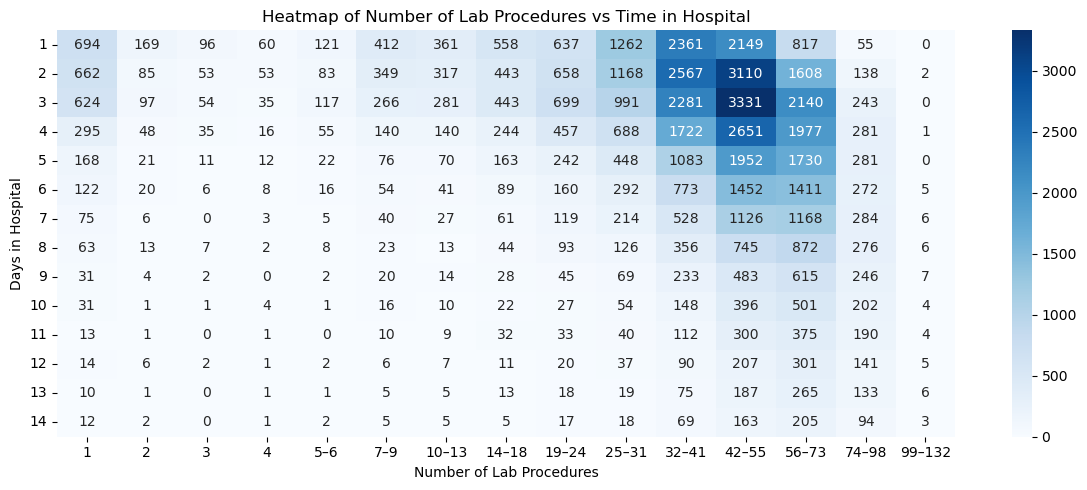

In [68]:
# Create roughly logarithmic bins for num_lab_procedures
bins = [1, 2, 3, 4, 5, 7, 10, 14, 19, 25, 32, 42, 56, 74, 99, 133]
bin_labels = [f'{bins[i]}–{bins[i+1] - 1}' if bins[i+1] - 1 > bins[i]
              else str(bins[i]) for i in range(len(bins)-1)]

# Compute binned values
num_lab_bins = pd.cut(
    X_train['num_lab_procedures'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
)

# Create crosstab
heatmap_data = pd.crosstab(X_train.time_in_hospital, num_lab_bins)

# Plot
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of Number of Lab Procedures vs Time in Hospital')
plt.ylabel('Days in Hospital')
plt.xlabel('Number of Lab Procedures')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

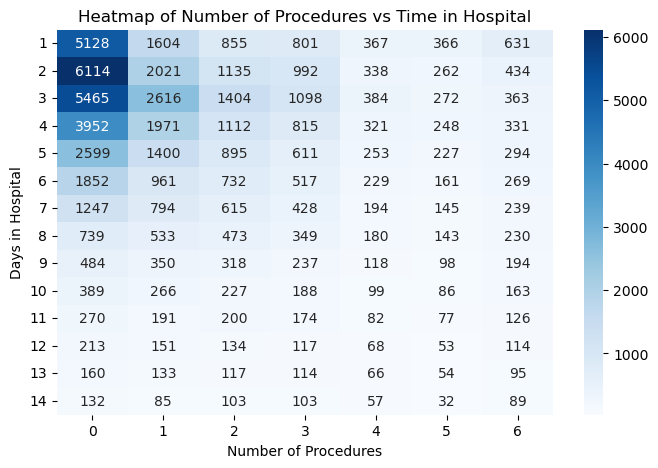

In [69]:
# Create the frequency table
heatmap_data = pd.crosstab(X_train.time_in_hospital, X_train.num_procedures)

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of Number of Procedures vs Time in Hospital')
plt.ylabel('Days in Hospital')
plt.xlabel('Number of Procedures')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

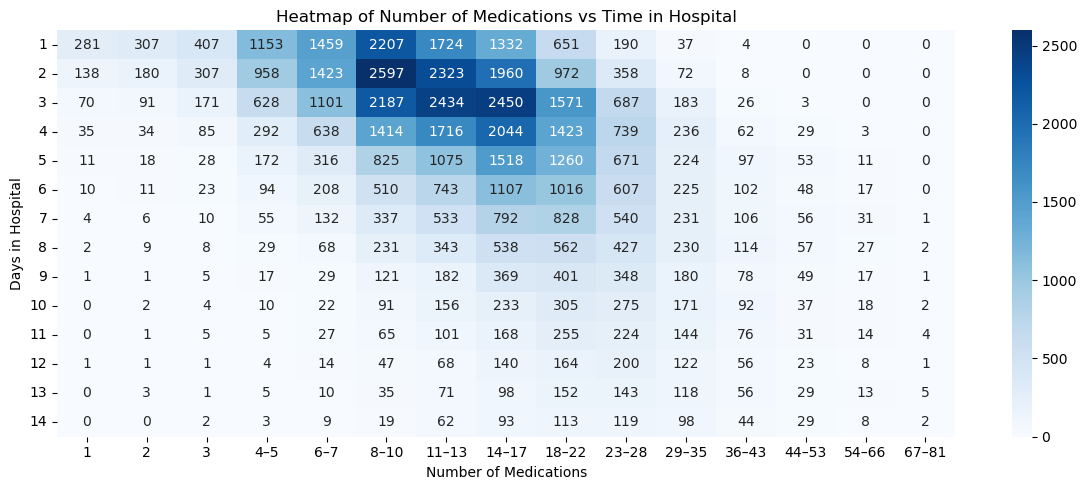

In [70]:
bins = [1, 2, 3, 4, 6, 8, 11, 14, 18, 23, 29, 36, 44, 54, 67, 82]
bin_labels = [f'{bins[i]}–{bins[i+1] - 1}' if bins[i+1] - 1 > bins[i]
              else str(bins[i]) for i in range(len(bins)-1)]

# Compute binned values
num_med_bins = pd.cut(
    X_train['num_medications'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True,
)

# Create crosstab
heatmap_data = pd.crosstab(X_train.time_in_hospital, num_med_bins)

# Plot
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of Number of Medications vs Time in Hospital')
plt.ylabel('Days in Hospital')
plt.xlabel('Number of Medications')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We are now done making changes to `X_train`, `X_test`, and `y_train`, so let's save these changes:

In [71]:
X_train.to_csv('X_train_processed.csv')
X_test.to_csv('X_test_processed.csv')
y_train.to_csv('y_train_processed.csv')
# y_test has not been changed

# 7. Feature selection

I will choose features by examining only `X_train`, and compute features for both training and test.

I view feature selection from an information theory perspective. I want to capture as much information as I can within a reasonable number of features. If there are many features that have very little information, they increase the chance of overfitting. My threshold is that every feature must have at least 100 values that differ from the majority value.

I also want to avoid introducing false information. For example, I've seen people encode categorical columns by replacing each category with a distinct integer, in the order the categories first appear. This effectively tells the machine learning model that category 1 is more similar to category 2 than to categories 5 through 10, which is unlikely to be true. I generally use one hot encoding for categorical columns. However, I will use my domain knowledge to identify and capture genuine similarities between categories.

This approach will yield over 400 features. Fortunately, machine learning models such as LightGBM and XGBoost can automatically identify the most important features.

This notebook computes features for both `X_train` and `X_test`, but it doesn't define a function that can
computes features for other inputs. Instead, it stores data about selected features in a JSON file. This
data will later be used for creating such a function. 

In [72]:
feature_data_dict = dict()

## 7.1 Diagnosis code features

Let's look at the 30 most common codes in the dataset:

In [73]:
code_counts = all_codes.value_counts()
code_counts.head(30)

250       13172
428        9808
401        9197
414        8759
276        7883
427        7032
599        4078
496        3582
786        3557
486        3308
410        3031
780        3023
403        2924
250.02     2752
682        2613
584        2413
491        2379
411        2350
285        1997
715        1988
707        1922
272        1832
585        1760
250.6      1746
518        1733
250.01     1687
493        1673
424        1578
434        1576
425        1532
Name: count, dtype: int64

When counting patients 
with a particular code, keep in mind that a code represents a condition. Any code starting with 250 indicates
that a patient has diabetes. If we create a feature for code 250, we should include all codes that start with 250. (<a href="footnotes">Note 2</a>) 
The same is true for the four-digit codes that start with 250. We can adjust `code_counts` to reflect this:

In [74]:
codes_with_children = ['250'] + ['250.' + str(i) for i in range(10)]

In [75]:
for code in codes_with_children:
    code_counts.loc[code] = all_codes.str.startswith(code).sum()

Now we can see the updated list of the 30 most common codes:

In [76]:
code_counts = code_counts.sort_values(ascending=False)
code_counts.head(30)

250       26002
428        9808
401        9197
414        8759
276        7883
427        7032
250.0      4836
599        4078
496        3582
786        3557
486        3308
410        3031
780        3023
403        2924
250.02     2752
682        2613
584        2413
491        2379
411        2350
285        1997
715        1988
250.8      1984
707        1922
272        1832
585        1760
250.6      1746
518        1733
250.01     1687
493        1673
250.1      1592
Name: count, dtype: int64

For the five most common codes, let's see how often they occur in each column (including the subcodes of 250):

In [77]:
for code in code_counts.index[:5]:
    print(
        code,
        {col: int((X_train[col].str.startswith(code)).sum())
         for col in code_columns_list})

250 {'diag_1': 5322, 'diag_2': 8988, 'diag_3': 11684}
428 {'diag_1': 3620, 'diag_2': 3862, 'diag_3': 2324}
401 {'diag_1': 239, 'diag_2': 2873, 'diag_3': 6079}
414 {'diag_1': 4838, 'diag_2': 1706, 'diag_3': 2213}
276 {'diag_1': 1104, 'diag_2': 4166, 'diag_3': 2611}


Diabetes is more common as a second or third diagnosis than as the primary diagnosis. 
Keep in mind that this is a dataset of hospitalized patients
with diabetes, not a dataset of patients hospitalized for diabetes. Diabetes is a common, chronic
condition that often can be controlled for years without hospital admission. Patients with diabetes may be admitted
for reasons unrelated to diabetes. I will make use of diabetes information in this dataset, but I'm 
guessing that for predicting readmission, most of the important features will not be about diabetes.

Codes 428 and 414 are very common as primary diagnoses. 
428 is Heart failure, which makes sense as the primary reason for an emergency room visit and admission.
414 is Other forms of chronic ischemic heart disease, which is likely a primary reason for surgery.
401 is Essential hypertension, another common condition that usually is not a reason for admission,
but is a risk factor for other conditions that may require admission.
276 is Disorders of fluid electrolyte and acid-base balance, which includes dehydration, a common
reason for admission.

**Making a feature for a code**

We want the feature for a code to include the more specific codes, similar to how we counted them above.

In [78]:
def make_code_feature(
    X_train: pd.DataFrame,
    code: str,
    code_columns: list = code_columns_list
) -> pd.Series:
    '''
    Make a feature representing an ICD-9 code.

    Args:
        X_train: Pandas DataFrame; its columns must include everything in
            code_columns
        code: string, ICD-9 code
        code_columns: list of strings

    Returns:
        Pandas boolean Series, with same index as X_train, indicating which
            patients have this code in one of the code_columns
    '''
    if code.startswith('250'):
        col = code_columns[0]
        feature = X_train[col].str.startswith(code)
        for col in code_columns[1:]:
            feature = feature | X_train[col].str.startswith(code)
    else:
        # we can't use startswith for all the codes, because some of them
        # are less than 3 characters (the leading zeroes are missing), so
        # this would pick up other 3-digit codes
        col = code_columns[0]
        feature = X_train[col] == code
        for col in code_columns[1:]:
            feature = feature | (X_train[col] == code)
    return feature

I will make features for every code that occurs in at least 100 patient records.

Note that `make_code_feature` has an argument called `X_train`, but I will apply it also to `X_test`.

In [79]:
common_codes = code_counts[code_counts >= 100].index
feature_data_dict['common_codes'] = list(common_codes)

code_features_train = pd.DataFrame(
    index=X_train.index,
    columns=['ICD9_' + code for code in common_codes]
)
code_features_test = pd.DataFrame(
    index=X_test.index,
    columns=['ICD9_' + code for code in common_codes]
)
for code in common_codes:
    code_features_train['ICD9_' + code] = make_code_feature(X_train, code)
    code_features_test['ICD9_' + code] = make_code_feature(X_test, code)
print(code_features_train.shape, code_features_test.shape)
code_features_train.head(10)

(65236, 219) (5000, 219)


,ICD9_250,ICD9_428,ICD9_401,ICD9_414,ICD9_276,ICD9_427,ICD9_250.0,ICD9_599,ICD9_496,ICD9_786,ICD9_486,ICD9_410,ICD9_780,ICD9_403,ICD9_250.02,ICD9_682,ICD9_584,ICD9_491,ICD9_411,ICD9_285,ICD9_715,ICD9_250.8,ICD9_707,ICD9_272,ICD9_585,...,ICD9_274,ICD9_250.51,ICD9_242,ICD9_431,ICD9_731,ICD9_465,ICD9_79,ICD9_716,ICD9_332,ICD9_723,ICD9_808,ICD9_714,ICD9_275,ICD9_596,ICD9_823,ICD9_726,ICD9_345,ICD9_807,ICD9_154,ICD9_568,ICD9_626,ICD9_581,ICD9_203,ICD9_250.52,ICD9_398
24248,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
93404,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
98028,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
31977,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
77979,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
54947,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
86972,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
23271,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40707,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
77187,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### 7.1.1 Primary diagnosis codes

The primary diagnosis is particularly important, so for each common primary diagnosis, I will make a feature identifying which patients have that primary diagnosis. The process is similar to the above, but uses only `diag_1` instead of all three code columns.

In [80]:
code_counts = X_train.diag_1.value_counts()

for code in codes_with_children:
    code_counts.loc[code] = X_train.diag_1.str.startswith(code).sum()

code_counts = code_counts.sort_values(ascending=False)
code_counts.head(30)

diag_1
250      5322
414      4838
428      3620
786      2826
410      2579
486      2210
427      1878
715      1781
434      1438
250.8    1386
682      1361
250.1    1350
780      1328
491      1209
276      1104
996      1026
38        944
599       923
584       875
820       728
574       714
435       699
250.0     695
562       660
577       627
493       625
V57       608
722       606
250.6     597
296       592
Name: count, dtype: int64

In [81]:
common_codes = code_counts[code_counts >= 100].index
feature_data_dict['common_primary_codes'] = list(common_codes)

primary_code_features_train = pd.DataFrame(
    index=X_train.index,
    columns=['primary_ICD9_' + code for code in common_codes]
)
primary_code_features_test = pd.DataFrame(
    index=X_test.index,
    columns=['primary_ICD9_' + code for code in common_codes]
)
for code in common_codes:
    primary_code_features_train['primary_ICD9_' + code] = make_code_feature(
        X_train,
        code,
        code_columns=['diag_1'],
    )
    primary_code_features_test['primary_ICD9_' + code] = make_code_feature(
        X_test,
        code,
        code_columns=['diag_1'],
    )
print(primary_code_features_train.shape, primary_code_features_test.shape)
primary_code_features_train.head(10)

(65236, 110) (5000, 110)


,primary_ICD9_250,primary_ICD9_414,primary_ICD9_428,primary_ICD9_786,primary_ICD9_410,primary_ICD9_486,primary_ICD9_427,primary_ICD9_715,primary_ICD9_434,primary_ICD9_250.8,primary_ICD9_682,primary_ICD9_250.1,primary_ICD9_780,primary_ICD9_491,primary_ICD9_276,primary_ICD9_996,primary_ICD9_38,primary_ICD9_599,primary_ICD9_584,primary_ICD9_820,primary_ICD9_574,primary_ICD9_435,primary_ICD9_250.0,primary_ICD9_562,primary_ICD9_577,...,primary_ICD9_707,primary_ICD9_600,primary_ICD9_511,primary_ICD9_575,primary_ICD9_185,primary_ICD9_721,primary_ICD9_424,primary_ICD9_618,primary_ICD9_331,primary_ICD9_730,primary_ICD9_557,primary_ICD9_436,primary_ICD9_174,primary_ICD9_805,primary_ICD9_218,primary_ICD9_821,primary_ICD9_250.81,primary_ICD9_250.22,primary_ICD9_V58,primary_ICD9_386,primary_ICD9_431,primary_ICD9_572,primary_ICD9_784,primary_ICD9_553,primary_ICD9_444
24248,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
93404,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
98028,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
31977,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
77979,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
54947,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
86972,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
23271,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40707,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
77187,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### 7.1.2 Code ranges

I will also create features that capture larger groups of related codes. According to https://en.wikipedia.org/wiki/List_of_ICD-9_codes, the following code ranges are meaningful:
- 001–139
- 140–239
- 240–279
- 280–289
- 290–319
- 320–389
- 390–459
- 460–519
- 520–579
- 580–629
- 630–679
- 680–709
- 710–739
- 740–759
- 760–779
- 780–799
- 800–999

This is how we can identify which patients have a code in each of these ranges:

In [82]:
code_nums_train = X_train[['diag_1', 'diag_2', 'diag_3']].apply(
    pd.to_numeric,
    errors='coerce'
)
ranges = [
    (1, 139),
    (140, 239),
    (240, 279),
    (280, 289),
    (290, 319),
    (320, 389),
    (390, 459),
    (460, 519),
    (520, 579),
    (580, 629),
    (630, 679),
    (680, 709),
    (710, 739),
    (740, 759),
    (760, 779),
    (780, 799),
    (800, 999)
]
range_features_train = dict()
for low, high in ranges:
    mask = code_nums_train.apply(
        lambda col: col.between(low, high),
        axis=0
    )
    range_features_train[f'ICD9_{low}-{high}'] = mask.any(axis=1)

range_features_train = pd.DataFrame(range_features_train)
range_features_train.sum(axis=0)

ICD9_1-139       3771
ICD9_140-239     3993
ICD9_240-279    33054
ICD9_280-289     4029
ICD9_290-319     4229
ICD9_320-389     2678
ICD9_390-459    37642
ICD9_460-519    13318
ICD9_520-579     8674
ICD9_580-629    10137
ICD9_630-679      546
ICD9_680-709     4352
ICD9_710-739     5434
ICD9_740-759      183
ICD9_760-779        0
ICD9_780-799    10065
ICD9_800-999     6266
dtype: int64

All of these will be features except 760-779. We also need to create these features
for `X_test`:

In [83]:
ranges.remove((760, 779))
feature_data_dict['code_ranges'] = ranges[:]

range_features_train = range_features_train.drop(columns=['ICD9_760-779'])

code_nums_test = X_test[['diag_1', 'diag_2', 'diag_3']].apply(
    pd.to_numeric,
    errors='coerce',
)

range_features_test = dict()
for low, high in ranges:
    mask = code_nums_test.apply(
        lambda col: col.between(low, high),
        axis=0
    )
    range_features_test[f'ICD9_{low}-{high}'] = mask.any(axis=1)

range_features_test = pd.DataFrame(range_features_test)
(range_features_train.shape, range_features_test.shape)

((65236, 16), (5000, 16))

Next, I will repeat this process using only the primary diagnosis:

In [84]:
primary_range_features_train = dict()
for low, high in ranges:
    primary_range_features_train[f'primary_ICD9_{low}-{high}'] = (
        code_nums_train['diag_1'].between(low, high)
    )

primary_range_features_train = pd.DataFrame(primary_range_features_train)
primary_range_features_train.sum(axis=0)

primary_ICD9_1-139       1586
primary_ICD9_140-239     2459
primary_ICD9_240-279     7057
primary_ICD9_280-289      595
primary_ICD9_290-319     1441
primary_ICD9_320-389      817
primary_ICD9_390-459    19880
primary_ICD9_460-519     6031
primary_ICD9_520-579     5909
primary_ICD9_580-629     3195
primary_ICD9_630-679      544
primary_ICD9_680-709     1662
primary_ICD9_710-739     3776
primary_ICD9_740-759       37
primary_ICD9_780-799     5136
primary_ICD9_800-999     4251
dtype: int64

All of these will be features except "primary_ICD9_740-759".

In [85]:
ranges.remove((740, 759))
feature_data_dict['primary_code_ranges'] = ranges

primary_range_features_train = primary_range_features_train.drop(
    columns=['primary_ICD9_740-759']
)

primary_range_features_test = dict()
for low, high in ranges:
    primary_range_features_test[f'primary_ICD9_{low}-{high}'] = (
        code_nums_test['diag_1'].between(low, high)
    )

primary_range_features_test = pd.DataFrame(primary_range_features_test)
(primary_range_features_train.shape, primary_range_features_test.shape)

((65236, 15), (5000, 15))

I've made four `DataFrame`s of training features. I'll now combine those all into
one `DataFrame`, and do the same for test:

In [86]:
code_features_train = pd.concat(
    [
        code_features_train,
        primary_code_features_train,
        range_features_train,
        primary_range_features_train,
    ],
    axis=1
)

code_features_test = pd.concat(
    [
        code_features_test,
        primary_code_features_test,
        range_features_test,
        primary_range_features_test,
    ],
    axis=1
)

(code_features_train.shape, code_features_test.shape)

((65236, 360), (5000, 360))

## 7.2 Other categorical features

### 7.2.1 Race

In [87]:
print_column_info('race')

type: object
values present: 63460 , values missing: 1776
unique: 5
Counts
race
Caucasian          48771
AfricanAmerican    11753
Hispanic            1413
Other               1080
Asian                443
Name: count, dtype: int64


I don't think "Other" is a useful category. The rest of these are.

In [88]:
category_features_train = pd.DataFrame(index=X_train.index)
category_features_test = pd.DataFrame(index=X_test.index)

races = list(X_train.race.dropna().unique())
races.remove('Other')
feature_data_dict['races'] = races

for race in races:
    category_features_train['race_' + race] = (
        X_train.race == race
    ).astype(float)
    category_features_test['race_' + race] = (
        X_test.race == race
    ).astype(float)

### 7.2.2 Payer code

I will make features for each payer that occurs at least 100 times.

In [89]:
print_column_info('payer_code')

type: object
values present: 36846 , values missing: 28390
unique: 17
Counts
payer_code
MC    18515
HM     3680
BC     3155
SP     3049
MD     2022
CP     1796
UN     1687
CM     1212
OG      612
PO      421
DM      360
WC      108
CH      104
OT       58
SI       37
MP       29
FR        1
Name: count, dtype: int64


In [90]:
payer_counts = X_train.payer_code.value_counts()
common_payers = payer_counts[payer_counts >= 100].index
feature_data_dict['common_payers'] = list(common_payers)

for payer in common_payers:
    category_features_train['payer_' + payer] = X_train.payer_code == payer
    category_features_test['payer_' + payer] = X_test.payer_code == payer

### 7.2.3 Medical specialty

In [91]:
print_column_info('medical_specialty')

Specialty of the admitting physician
type: object
values present: 33753 , values missing: 31483
unique: 70
count                33753
unique                  70
top       InternalMedicine
freq                  9861
Name: medical_specialty, dtype: object
Counts of 20 most common values
medical_specialty
InternalMedicine                     9861
Family/GeneralPractice               4652
Emergency/Trauma                     4090
Cardiology                           3918
Surgery-General                      2036
Orthopedics                          1045
Orthopedics-Reconstructive            940
Radiologist                           771
Nephrology                            731
Pulmonology                           609
Psychiatry                            582
ObstetricsandGynecology               551
Urology                               478
Surgery-Cardiovascular/Thoracic       454
Surgery-Neuro                         368
Gastroenterology                      363
Surgery-Vascular        

There are 24 specialties that occur at least 100 times. Also, I'd like to examine some 
specialties than occur less than 100 times, because that may be helpful in identifying
similarities between specialties. However, I don't think it's worth the trouble to look 
at all 70. I'll print out every specialty that occurs at least 20 times:

In [92]:
specialty_counts = X_train.medical_specialty.value_counts()
for specialty in specialty_counts.index:
    count = specialty_counts.loc[specialty]
    if count >= 20:
        print(specialty, count)

InternalMedicine 9861
Family/GeneralPractice 4652
Emergency/Trauma 4090
Cardiology 3918
Surgery-General 2036
Orthopedics 1045
Orthopedics-Reconstructive 940
Radiologist 771
Nephrology 731
Pulmonology 609
Psychiatry 582
ObstetricsandGynecology 551
Urology 478
Surgery-Cardiovascular/Thoracic 454
Surgery-Neuro 368
Gastroenterology 363
Surgery-Vascular 336
Oncology 186
Pediatrics 182
PhysicalMedicineandRehabilitation 177
Neurology 156
Pediatrics-Endocrinology 140
Hematology/Oncology 111
Otolaryngology 104
Endocrinology 88
Surgery-Thoracic 78
Surgery-Cardiovascular 75
Pediatrics-CriticalCare 72
Podiatry 58
Psychology 48
Gynecology 47
Radiology 37
Surgeon 37
Osteopath 36
Hospitalist 34
Ophthalmology 33
Hematology 30
Surgery-Plastic 28
InfectiousDiseases 24
SurgicalSpecialty 24


As before, I want to have a feature for every category that occurs at least 100 times, but I'll make
some adjustments due to similarities between categories.

It helps to keep in mind how the machine learning model will interact with these features. I plan
to use XGBoost and LightGBM. They work by repeatedly splitting a group of patients into two smaller
groups according to the value of a single feature. I have to decide which splits are useful, and
design features to enable those splits. 

Hematology, Oncology, and Hematology/Oncology are all closely related. I see four good ways to
use them for splits:
- Split Hematology/Oncology from everything else
- Split Hematology/Oncology and Hematology from everything else
- Split Hematology/Oncology and Oncology from everything else
- Split all three from everything else

These splits can be enabled with three features:
1. A "Hematology" feature that includes "Hematology/Oncology"
2. An "Oncology" feature that includes "Hematology/Oncology"
3. A "Hematology/Oncology" feature that has value 1 for "Hematology/Oncology", 0.5 for "Hematology" and "Oncology", and 0 for everything else.

I will also make these adjusments to reflect other similarities between categories:

4. I will have a "Orthopedics-Reconstructive" feature, but I'll also include these patients under "Orthopedics"
5. The "Pediatrics" feature will include all values that contain "Pediat"
6. "Pediatrics-Endocrinology" patients will also be included in an "Endocrinology" feature; there will be no "Pediatrics-Endocrinology" feature
7. The "Psychiatry" feature will include "Psychology" patients
8. The "Surgery-General" feature will include "Surgeon" and "SurgicalSpecialty"
9. I will add a "Surgery" feature, including all values that contain "Surg"
10. The "ObstetricsandGynecology" feature will include "Gynecology"
11. There will be a "Surgery-Thoracic" feature that includes "Surgery-Cardiovascular/Thoracic"
12. There will be a "Surgery-Cardiovascular" feature that includes "Surgery-Cardiovascular/Thoracic"
13. The "Surgery-Cardiovascular/Thoracic" feature will have value 0.5 for "Surgery-Thoracic" and "Surgery-Cardiovascular"
14. The "Radiologist" feature will include "Radiology".

In [93]:
specialty_counts = X_train.medical_specialty.value_counts()
common_specialties = specialty_counts[specialty_counts >= 100].index
feature_data_dict['common_specialties'] = list(common_specialties)

for data_df, feature_df in [
    (X_train, category_features_train),
    (X_test, category_features_test)
]:
    for specialty in common_specialties:
        feature_df['specialty_' + specialty] = (
            data_df.medical_specialty == specialty).astype(float)

    # 1 A "Hematology" feature that includes "Hematology/Oncology"
    feature_df['specialty_Hematology'] = (
        (data_df.medical_specialty == 'Hematology')
        | (data_df.medical_specialty == 'Hematology/Oncology')
    )
    # 2 An "Oncology" feature that includes "Hematology/Oncology"
    feature_df['specialty_Oncology'] = (
        (data_df.medical_specialty == 'Oncology')
        | (data_df.medical_specialty == 'Hematology/Oncology')
    )
    # 3 A "Hematology/Oncology" feature that has value 1 for
    # "Hematology/Oncology", 0.5 for "Hematology" and "Oncology",
    # and 0 for everything else.
    feature_df.loc[
        data_df.medical_specialty == 'Hematology',
        'specialty_Hematology/Oncology'
    ] = 0.5
    feature_df.loc[
        data_df.medical_specialty == 'Hematology',
        'specialty_Hematology/Oncology'
    ] = 0.5
    # 4 include "Orthopedics-Reconstructive" patients under "Orthopedics"
    feature_df.specialty_Orthopedics = (
        (data_df.medical_specialty == 'Orthopedics')
        | (data_df.medical_specialty == 'Orthopedics-Reconstructive')
    )
    # 5 The "Pediatrics" feature will include all values that contain "Pediat"
    # case insensitive
    feature_df.specialty_Pediatrics = (
        ~data_df.medical_specialty.isna()
        & data_df.medical_specialty.str.lower().str.contains('pediat')
    )
    # 6 "Pediatrics-Endocrinology" patients will also be included in an
    # "Endocrinology" feature; there will be no "Pediatrics-Endocrinology"
    # feature
    feature_df.drop(
        columns='specialty_Pediatrics-Endocrinology',
        inplace=True
    )
    feature_df['specialty_Endocrinology'] = (
        ~data_df.medical_specialty.isna()
        & data_df.medical_specialty.str.lower().str.contains('endocrin')
    )
    # 7 The "Psychiatry" feature will include "Psychology" patients
    feature_df.specialty_Psychiatry = (
        (data_df.medical_specialty == 'Psychiatry')
        | (data_df.medical_specialty == 'Psychology')
    )
    # 8 The "Surgery-General" feature will include "Surgeon" and
    # "SurgicalSpecialty"
    feature_df['specialty_Surgery-General'] = (
        (data_df.medical_specialty == 'Surgery-General')
        | (data_df.medical_specialty == 'Surgeon')
        | (data_df.medical_specialty == 'SurgicalSpecialty')
    )
    # 9. add a "Surgery" feature, including all values that contain "Surg"
    feature_df['specialty_Surgery'] = (
        ~data_df.medical_specialty.isna()
        & data_df.medical_specialty.str.lower().str.contains('surg')
    )
    # 10. The "ObstetricsandGynecology" feature will include "Gynecology"
    feature_df.specialty_ObstetricsandGynecology = (
        ~data_df.medical_specialty.isna()
        & data_df.medical_specialty.str.lower().str.contains('gynec')
    )
    # 11. a "Surgery-Thoracic" feature that includes
    # "Surgery-Cardiovascular/Thoracic"
    feature_df['specialty_Surgery-Thoracic'] = (
        (data_df.medical_specialty == 'Surgery-Thoracic')
        | (data_df.medical_specialty == 'Surgery-Cardiovascular/Thoracic')
    )
    # 12. There will be a "Surgery-Cardiovascular" feature that includes
    # "Surgery-Cardiovascular/Thoracic"
    feature_df['specialty_Surgery-Cardiovascular'] = (
        (data_df.medical_specialty == 'Surgery-Cardiovascular')
        | (data_df.medical_specialty == 'Surgery-Cardiovascular/Thoracic')
    )
    # 13. The "Surgery-Cardiovascular/Thoracic" feature will have value 0.5
    # for "Surgery-Thoracic" and "Surgery-Cardiovascular"
    feature_df.loc[
        data_df.medical_specialty == 'Surgery-Thoracic',
        'specialty_Surgery-Cardiovascular/Thoracic'
    ] = 0.5
    feature_df.loc[
        data_df.medical_specialty == 'Surgery-Cardiovascular',
        'specialty_Surgery-Cardiovascular/Thoracic'
    ] = 0.5
    # 14. The "Radiologist" feature will include "Radiology".
    feature_df.specialty_Radiologist = (
        ~data_df.medical_specialty.isna()
        & data_df.medical_specialty.str.lower().str.contains('radiol')
    )

In [94]:
# Test
for col in category_features_train.columns:
    if col.startswith('specialty'):
        print(col)
        print(
            X_train.loc[
                category_features_train[col] > 0,
                'medical_specialty'].value_counts()
             )

specialty_InternalMedicine
medical_specialty
InternalMedicine    9861
Name: count, dtype: int64
specialty_Family/GeneralPractice
medical_specialty
Family/GeneralPractice    4652
Name: count, dtype: int64
specialty_Emergency/Trauma
medical_specialty
Emergency/Trauma    4090
Name: count, dtype: int64
specialty_Cardiology
medical_specialty
Cardiology    3918
Name: count, dtype: int64
specialty_Surgery-General
medical_specialty
Surgery-General      2036
Surgeon                37
SurgicalSpecialty      24
Name: count, dtype: int64
specialty_Orthopedics
medical_specialty
Orthopedics                   1045
Orthopedics-Reconstructive     940
Name: count, dtype: int64
specialty_Orthopedics-Reconstructive
medical_specialty
Orthopedics-Reconstructive    940
Name: count, dtype: int64
specialty_Radiologist
medical_specialty
Radiologist    771
Radiology       37
Name: count, dtype: int64
specialty_Nephrology
medical_specialty
Nephrology    731
Name: count, dtype: int64
specialty_Pulmonology
medical_

### 7.2.4 Glucose

In [95]:
print_column_info('max_glu_serum')

Indicates the range of the serum glucose result or if the test was not taken. Values: “>200”, “>300”, “normal”, and “none” if not measured
type: object
values present: 65236 , values missing: 0
unique: 4
Counts
max_glu_serum
None    62089
Norm     1597
>200      875
>300      675
Name: count, dtype: int64


I don't want to impute values for patients that didn't get a test, because there may be reasons
why those patients weren't tested, so the tested patients may not well represent the untested patients.
Instead, I'll use categorical features for the three test results.

In [96]:
glucose_results = ['Norm', '>200', '>300']
feature_data_dict['glucose_results'] = glucose_results

for result in glucose_results:
    category_features_train['glucose_' + result] = (
        X_train.max_glu_serum == result
    )
    category_features_test['glucose_' + result] = (
        X_test.max_glu_serum == result
    )

In [97]:
print_column_info('A1Cresult')

Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured. Includes results from up to three months before admission
type: object
values present: 65236 , values missing: 0
unique: 4
Counts
A1Cresult
None    53297
>8       5793
Norm     3478
>7       2668
Name: count, dtype: int64


I'll use the same approach I used for the previous column.

In [98]:
a1c_results = ['Norm', '>7', '>8']
feature_data_dict['a1c_results'] = a1c_results

for result in a1c_results:
    category_features_train['a1c_' + result] = X_train.A1Cresult == result
    category_features_test['a1c_' + result] = X_test.A1Cresult == result

### 7.2.5 Specific medication columns

Let's look at the first three:

In [99]:
for col in specific_med_columns[:3]:
    print_column_info(col)

Indicates whether metformin was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed
type: object
values present: 65236 , values missing: 0
unique: 4
Counts
metformin
No        51379
Steady    12672
Up          779
Down        406
Name: count, dtype: int64
Indicates whether repaglinide was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed
type: object
values present: 65236 , values missing: 0
unique: 4
Counts
repaglinide
No        64366
Steady      779
Up           66
Down         25
Name: count, dtype: int64
Indicates whether nateglinide was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the en

None of these have any missing values. Is that true for all 23?

In [100]:
print(X_train[specific_med_columns].isna().sum().sum())

0


For each medication, I'll make three features 
1. all patients who took the medication,
2. patients whose dose of that medication went up,
3. patients whose dose of that medication went down,

but I'll exclude any feature with fewer than 100 patients.
I'll also add another feature for the total number of medications the patient
took out of these 23.

In [101]:
med_features_train = pd.DataFrame(
    index=X_train.index,
    columns=specific_med_columns,
)
med_features_test = pd.DataFrame(
    index=X_test.index,
    columns=specific_med_columns,
)

for col in specific_med_columns:
    # Since there are no missing values, any value other than
    # 'No' is a patient who took this medication
    med_features_train[col] = ~(X_train[col] == 'No')
    med_features_test[col] = ~(X_test[col] == 'No')

# We compute these sums now, before deleting some of the columns.
# In Section 7.3 they will be included
# in DataFrames with other numeric features.
num_specific_meds_train = med_features_train.sum(axis=1)
num_specific_meds_test = med_features_test.sum(axis=1)

med_features_up_train = pd.DataFrame(
    index=X_train.index,
    columns=[col + '_up' for col in specific_med_columns],
)
med_features_down_train = pd.DataFrame(
    index=X_train.index,
    columns=[col + '_down' for col in specific_med_columns],
)
for col in specific_med_columns:
    med_features_up_train[col + '_up'] = (X_train[col] == 'Up')
    med_features_down_train[col + '_down'] = (X_train[col] == 'Down')

med_features_up_test = pd.DataFrame(
    index=X_test.index,
    columns=[col + '_up' for col in specific_med_columns],
)
med_features_down_test = pd.DataFrame(
    index=X_test.index,
    columns=[col + '_down' for col in specific_med_columns],
)
for col in specific_med_columns:
    med_features_up_test[col + '_up'] = (X_test[col] == 'Up')
    med_features_down_test[col + '_down'] = (X_test[col] == 'Down')

# Combine all med categorical features
med_features_train = pd.concat(
    [med_features_train, med_features_up_train, med_features_down_train],
    axis=1,
    copy=False,
)
med_features_test = pd.concat(
    [med_features_test, med_features_up_test, med_features_down_test],
    axis=1,
    copy=False,
)
print(med_features_train.shape, med_features_test.shape)

med_features_train.head(10)

(65236, 69) (5000, 69)


,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,sitagliptin,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,metformin_up,repaglinide_up,...,metformin-rosiglitazone_up,metformin-pioglitazone_up,metformin_down,repaglinide_down,nateglinide_down,chlorpropamide_down,glimepiride_down,acetohexamide_down,glipizide_down,glyburide_down,tolbutamide_down,pioglitazone_down,rosiglitazone_down,acarbose_down,miglitol_down,troglitazone_down,tolazamide_down,examide_down,sitagliptin_down,insulin_down,glyburide-metformin_down,glipizide-metformin_down,glimepiride-pioglitazone_down,metformin-rosiglitazone_down,metformin-pioglitazone_down
24248,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
93404,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
98028,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
31977,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
77979,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
54947,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
86972,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
23271,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40707,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
77187,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [102]:
med_feature_sums_train = med_features_train.sum(axis=0)
# Keep only the columns with >= 100 patients
med_features_train = med_features_train.loc[:, med_feature_sums_train >= 100]
med_features_test = med_features_test.loc[:, med_feature_sums_train >= 100]

feature_data_dict['med_features'] = list(med_features_train.columns)

(med_features_train.shape, med_features_test.shape)

((65236, 23), (5000, 23))

In [103]:
category_features_train = pd.concat(
    [category_features_train, med_features_train],
    axis=1,
    copy=False,
)
category_features_test = pd.concat(
    [category_features_test, med_features_test],
    axis=1,
    copy=False,
)

### 7.2.6 Admission type

In [104]:
print_column_info('admission_type')

type: object
values present: 61012 , values missing: 4224
unique: 7
Counts
admission_type
Emergency        33124
Elective         12834
Urgent           11875
Not Available     2889
Not Mapped         273
Trauma Center       16
Newborn              1
Name: count, dtype: int64


I don't know what "Not available" and "Not mapped" mean, but it's 
possible that they could have some predictive value. I'll create
a feature for each value that occurs more than 100 times.

In [105]:
admit_type_counts = X_train.admission_type.value_counts()
common_admit_types = admit_type_counts[admit_type_counts >= 100].index
feature_data_dict['common_admit_types'] = list(common_admit_types)

for admit_type in common_admit_types:
    category_features_train['admit_type_' + admit_type] = (
        X_train.admission_type == admit_type
    )
    category_features_test['admit_type_' + admit_type] = (
        X_test.admission_type == admit_type
    )

### 7.2.7 Admission source

In [106]:
print_column_info('admission_source')

type: object
values present: 60713 , values missing: 4523
unique: 13
Counts
admission_source
 Emergency Room                                               34854
 Physician Referral                                           20231
Transfer from a hospital                                       2367
 Transfer from another health care facility                    1569
Clinic Referral                                                 848
 Transfer from a Skilled Nursing Facility (SNF)                 475
 Not Mapped                                                     136
HMO Referral                                                    128
 Not Available                                                   82
 Court/Law Enforcement                                           11
 Transfer from critial access hospital                            7
 Transfer from hospital inpt/same fac reslt in a sep claim        3
 Transfer from Ambulatory Surgery Center                          2
Name: count, dtype: int

Again, I'll create a feature for each that occurs more than 100 times.

In [107]:
admit_source_counts = X_train.admission_source.value_counts()
common_admit_sources = admit_source_counts[admit_source_counts >= 100].index
feature_data_dict['common_admit_sources'] = list(common_admit_sources)

for admit_source in common_admit_sources:
    category_features_train['admit_source_' + admit_source] = (
        X_train.admission_source == admit_source
    )
    category_features_test['admit_source_' + admit_source] = (
        X_test.admission_source == admit_source
    )

### 7.2.8 Discharge disposition

In [108]:
print_column_info('discharge_disposition')

type: object
values present: 62936 , values missing: 2300
unique: 21
count                  62936
unique                    21
top       Discharged to home
freq                   40995
Name: discharge_disposition, dtype: object
Counts of 20 most common values
discharge_disposition
Discharged to home                                                                                           40995
Discharged/transferred to SNF                                                                                 8172
Discharged/transferred to home with home health service                                                       7691
Discharged/transferred to another short term hospital                                                         1436
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1306
Discharged/transferred to another type of inpatient care institution                                           847
Not Mapped                  

Again, I'll create a feature for any value that occurs at least 100 times.
I'll also create features for three groups of values: to home, to hospital,
and to other facilities.

In [109]:
discharge_counts = X_train.discharge_disposition.value_counts()
common_discharges = discharge_counts[discharge_counts >= 100].index
feature_data_dict['common_discharges'] = list(common_discharges)

for discharge in common_discharges:
    category_features_train['discharge_' + discharge] = (
        X_train.discharge_disposition == discharge)
    category_features_test['discharge_' + discharge] = (
        X_test.discharge_disposition == discharge)

# keywords used to identify discharge groups
discharge_keywords = {
    'home': ['home'],
    'hospital': [
        'hospital',
        'swing bed',
    ],
    'facility': [
        'to SNF',
        'to another type of inpatient care institution',
        'to ICF',
        'Hospice / medical facility',
        'to a nursing facility',
        'to a federal health care facility',
    ],
}
feature_data_dict['discharge_keywords'] = discharge_keywords

for group, keywords in discharge_keywords.items():
    # Initially create feature as all 0's
    category_features_train['discharge_' + group] = 0
    category_features_test['discharge_' + group] = 0
    # Then find patients with discharge_disposition containing a keyword
    for keyword in keywords:
        category_features_train['discharge_' + group] = (
            category_features_train['discharge_' + group]
            | X_train.discharge_disposition.str.contains(keyword)
        )
        category_features_test['discharge_' + group] = (
            category_features_test['discharge_' + group]
            | X_test.discharge_disposition.str.contains(keyword)
        )

# Check results
print(category_features_train.shape, category_features_test.shape)
category_features_train.sum(axis=0).tail(30)

(65236, 102) (5000, 102)


glyburide_down                                                                                   386.0
insulin_down                                                                                    6820.0
admit_type_Emergency                                                                           33124.0
admit_type_Elective                                                                            12834.0
admit_type_Urgent                                                                              11875.0
admit_type_Not Available                                                                        2889.0
admit_type_Not Mapped                                                                            273.0
admit_source_ Emergency Room                                                                   34854.0
admit_source_ Physician Referral                                                               20231.0
admit_source_Transfer from a hospital                                    

## 7.3 Numeric features

### 7.3.1 Gender

In [110]:
print_column_info('gender')

type: object
values present: 65236 , values missing: 0
unique: 3
Counts
gender
Female             34700
Male               30534
Unknown/Invalid        2
Name: count, dtype: int64


I'll encode "Female" as `0`, and "Male" as `1`.

In [111]:
numeric_features_train = pd.DataFrame(index=X_train.index, columns=['gender'])
numeric_features_train.gender = np.nan
numeric_features_train.loc[X_train.gender == 'Female', 'gender'] = 0
numeric_features_train.loc[X_train.gender == 'Male', 'gender'] = 1
numeric_features_test = pd.DataFrame(index=X_test.index, columns=['gender'])
numeric_features_test.gender = np.nan
numeric_features_test.loc[X_test.gender == 'Female', 'gender'] = 0
numeric_features_test.loc[X_test.gender == 'Male', 'gender'] = 1

### 7.3.2 Age

In [112]:
print_column_info('age')

type: object
values present: 65236 , values missing: 0
unique: 10
Counts
age
[70-80)     16635
[60-70)     14542
[50-60)     11445
[80-90)     10413
[40-50)      6331
[30-40)      2509
[90-100)     1680
[20-30)      1038
[10-20)       495
[0-10)        148
Name: count, dtype: int64


The age is given as a range, 10 years wide. In general, our best guess is the center of that range. We still have one patient with admission type "Newborn", whose age should be 0, but I choose not to trust that information.

In [113]:
for age in range(0, 100, 10):
    age_string = f'[{age}-{age + 10})'
    numeric_features_train.loc[X_train.age == age_string, 'age'] = age + 5
    numeric_features_test.loc[X_test.age == age_string, 'age'] = age + 5
numeric_features_train.age.value_counts().sort_index()

age
5.0       148
15.0      495
25.0     1038
35.0     2509
45.0     6331
55.0    11445
65.0    14542
75.0    16635
85.0    10413
95.0     1680
Name: count, dtype: int64

### 7.3.3 Weight

In [114]:
print_column_info('weight')

Weight in kilograms
type: object
values present: 2635 , values missing: 62601
unique: 9
Counts
weight
[75-100)     1108
[50-75)       712
[100-125)     524
[125-150)     125
[25-50)        82
[0-25)         43
[150-175)      32
[175-200)       8
>200            1
Name: count, dtype: int64


I'll treat weight like I treated age: convert each range to its middle value.

In [115]:
for weight in range(0, 200, 25):
    weight_string = f'[{weight}-{weight + 25})'
    numeric_features_train.loc[
        X_train.weight == weight_string, 'weight'] = weight + 12.5
    numeric_features_test.loc[
        X_test.weight == weight_string, 'weight'] = weight + 12.5
numeric_features_train.loc[X_train.weight == '>200', 'weight'] = 212.5
numeric_features_test.loc[X_test.weight == '>200', 'weight'] = 212.5
numeric_features_train.weight.value_counts().sort_index()

weight
12.5       43
37.5       82
62.5      712
87.5     1108
112.5     524
137.5     125
162.5      32
187.5       8
212.5       1
Name: count, dtype: int64

### 7.3.4 Time in hospital

In [116]:
print_column_info('time_in_hospital')

in days
type: int64
values present: 65236 , values missing: 0
unique: 14
Counts
time_in_hospital
3     11602
2     11296
1      9752
4      8750
5      6279
6      4721
7      3662
8      2647
9      1799
10     1418
11     1120
12      850
13      739
14      601
Name: count, dtype: int64


This is numeric, no data is missing, so this can be used as is.

In [117]:
numeric_features_train['time_in_hospital'] = X_train.time_in_hospital
numeric_features_test['time_in_hospital'] = X_test.time_in_hospital

### 7.3.5 Counts of procedures, medications, visits, and diagnoses

In [118]:
count_columns = [
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses'
]
for column in count_columns:
    print(column)
    print_column_info(column)

num_lab_procedures
during the encounter
type: int64
values present: 65236 , values missing: 0
unique: 115
count    65236.000000
mean        42.932215
std         19.919108
min          1.000000
25%         31.000000
50%         44.000000
75%         57.000000
max        132.000000
Name: num_lab_procedures, dtype: float64
Counts of 20 most common values
num_lab_procedures
1     2108
43    1730
44    1545
45    1491
38    1425
46    1404
40    1376
47    1367
39    1336
37    1325
41    1319
42    1301
48    1295
49    1267
35    1227
51    1218
50    1209
36    1203
54    1181
55    1174
Name: count, dtype: int64
Counts of counts of other values
count
1127    2
1123    1
1121    1
1080    1
1056    1
       ..
6       1
4       3
3       2
2       4
1       5
Name: count, Length: 78, dtype: int64
num_procedures
during the encounter, not counting lab tests
type: int64
values present: 65236 , values missing: 0
unique: 7
Counts
num_procedures
0    28744
1    13076
2     8320
3     6544
6  

All 7 of these are numeric, with no missing values. They can be used as is.

In [119]:
for column in count_columns:
    numeric_features_train[column] = X_train[column]
    numeric_features_test[column] = X_test[column]
(numeric_features_train.shape, numeric_features_test.shape)

((65236, 11), (5000, 11))

### 7.3.6 Specific medication columns

As mentioned in Section 7.2.5, I will create a feature for the number of 
specific medications taken by the patient.

In [120]:
numeric_features_train['num_specific_meds'] = num_specific_meds_train
numeric_features_test['num_specific_meds'] = num_specific_meds_test
print(numeric_features_train['num_specific_meds'].value_counts())

num_specific_meds
1    29094
0    15565
2    14340
3     5250
4      936
5       47
6        4
Name: count, dtype: int64


### 7.3.7 Columns for all medications

In [121]:
print_column_info('diabetesMed')

Indicates if there was any diabetic medication prescribed
type: object
values present: 65236 , values missing: 0
unique: 2
Counts
diabetesMed
Yes    49671
No     15565
Name: count, dtype: int64


We don't need a feature for this column, because it contains no new information.
The patients with 'No' are the same that have 0 for
`numeric_features_train['num_specific_meds']`.

In [122]:
print_column_info('change')

Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
type: object
values present: 65236 , values missing: 0
unique: 2
Counts
change
No    35918
Ch    29318
Name: count, dtype: int64


As mentioned in Section 6.12, this column does contain new information. I'll 
encode "No" as 0 and "Ch" as 1.

In [123]:
numeric_features_train['change'] = (X_train.change == 'Ch').astype(int)
numeric_features_test['change'] = (X_test.change == 'Ch').astype(int)
(numeric_features_train.shape, numeric_features_test.shape)

((65236, 13), (5000, 13))

## 7.4 Combine all features

In [124]:
features_train = pd.concat(
    [
        code_features_train.astype(float),
        category_features_train.astype(float),
        numeric_features_train,
    ],
    axis=1,
)
features_train.to_csv('features_train.csv')
features_test = pd.concat(
    [
        code_features_test.astype(float),
        category_features_test.astype(float),
        numeric_features_test,
    ],
    axis=1,
)
features_test.to_csv('features_test.csv')

In [125]:
with open('feature_data.json', 'w') as fp:
    json.dump(feature_data_dict, fp)

# 8 Missing values

In addition to LightGBM and XGBoost, I will use CatBoost. All three of these can accept missing 
values, so I won't fill them in. Only two features have missing values:

In [126]:
nans = features_train.isna().sum(axis=0)
nans[nans > 0]

gender        2
weight    62601
dtype: int64

In [127]:
print('Elapsed time:', time.time() - start_time, 'seconds')

Elapsed time: 33.70309257507324 seconds


# 9 Modeling

## 9.1 Hyperparameter tuning

I wil split the training data into a training set and a validation set:

In [120]:
# y_train will get split, so save unsplit version
y_train_all = y_train

X_train, X_val, y_train, y_val = train_test_split(
    features_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=0,
)
[df.shape for df in [X_train, X_val, y_train, y_val]]

[(52188, 452), (13048, 452), (52188,), (13048,)]

I will use the optuna package to automatically select combinations of hyperparameters.

### 9.1.1 LightGBM

In [121]:
def lgb_objective(trial: optuna.trial.Trial) -> float:
    '''
    Train a repeatable LightGBM model with hyperparameters chosen by Optuna

    Optuna uses the Trial object to choose hyperparameters and
    report the choices back to the study. Repeatability is achieved
    by specifying all random seeds used in LightGBM.

    Args:
        trial: an object generated by Optuna's study.optimize function

    Returns:
        ROC-AUC achieved when the trained LightGBM model is tested on
        the validation set
    '''
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -2,
        'n_jobs': -1,
        'seed': 42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'data_random_seed': 42,
        'learning_rate': trial.suggest_float(
            'learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 6, 200),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 10.0, log=True),
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
        ],
    )

    y_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    return auc

In [122]:
# -----------------------------
# Run Optuna optimization
# -----------------------------
sampler = optuna.samplers.TPESampler(seed=42)
lgb_study = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    study_name='lgb_study',
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
lgb_study.optimize(lgb_objective, n_trials=1000)
print('Elapsed time:', time.time() - start_time, 'seconds')

[I 2025-10-16 13:52:18,816] A new study created in memory with name: lgb_study


Elapsed time: 823.9308099746704 seconds


### 9.1.2 XGBoost

In [123]:
def xgb_objective(trial: optuna.trial.Trial) -> float:
    '''
    Train a repeatable XGBoost model with hyperparameters chosen by Optuna

    Optuna uses the Trial object to choose hyperparameters and
    report the choices back to the study. Repeatability is achieved
    by specifying XGBoost's random seed.

    Args:
        trial: an object generated by Optuna's study.optimize function

    Returns:
        ROC-AUC achieved when the trained XGBoost model is tested on
        the validation set
    '''
    param = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float(
            'learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 18),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 180.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'use_label_encoder': False,
        'n_jobs': -1,
        'early_stopping_rounds': 50,
        'random_state': 42,
    }

    model = xgb.XGBClassifier(**param)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc

In [124]:
# -----------------------------
# Run Optuna optimization
# -----------------------------
sampler = optuna.samplers.TPESampler(seed=42)
xgb_study = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    study_name='xgb_study',
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
xgb_study.optimize(xgb_objective, n_trials=500)
print('Elapsed time:', time.time() - start_time, 'seconds')

Elapsed time: 7880.752409696579 seconds


### 9.1.3 CatBoost

In [125]:
def catboost_objective(trial: optuna.trial.Trial) -> float:
    '''
    Train a repeatable CatBoost model with hyperparameters chosen by Optuna

    Optuna uses the Trial object to choose hyperparameters and
    report the choices back to the study. Repeatability is achieved
    by specifying CatBoost's random seed.

    Args:
        trial: an object generated by Optuna's study.optimize function

    Returns:
        ROC-AUC achieved when the trained CatBoost model is tested on
        the validation set
    '''
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float(
            'learning_rate', 1e-3, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float(
            'l2_leaf_reg', 1e-8, 100.0, log=True),
        'random_strength': trial.suggest_float(
            'random_strength', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float(
            'bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'verbose': False,
        'random_seed': 42,
        'task_type': 'CPU',
    }

    model = CatBoostClassifier(**param)
    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False,
    )
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc

In [126]:
# -----------------------------
# Run Optuna optimization
# -----------------------------
sampler = optuna.samplers.TPESampler(seed=42)
catb_study = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    study_name='catb_study',
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
catb_study.optimize(catboost_objective, n_trials=500)
print('Elapsed time:', time.time() - start_time, 'seconds')

Elapsed time: 14820.58071231842 seconds


In [127]:
# Print best hyperparameters
print('LightGBM')
print(lgb_study.best_params)
print('XGBoost')
print(xgb_study.best_params)
print('CatBoost')
print(catb_study.best_params)

LightGBM
{'learning_rate': 0.10799001986021554, 'n_estimators': 164, 'num_leaves': 122, 'max_depth': 11, 'min_child_samples': 12, 'subsample': 0.5987387847783838, 'colsample_bytree': 0.5591840279456893, 'lambda_l1': 4.180490366739751, 'lambda_l2': 0.010455182201741256}
XGBoost
{'learning_rate': 0.026989207582488534, 'max_depth': 13, 'min_child_weight': 7, 'subsample': 0.5162557896336163, 'colsample_bytree': 0.5512692008632831, 'gamma': 1.6594966572500995, 'reg_alpha': 2.351533220761097, 'reg_lambda': 2.3512389061407404e-06}
CatBoost
{'iterations': 502, 'learning_rate': 0.05185548784664836, 'depth': 10, 'l2_leaf_reg': 19.46166542388837, 'random_strength': 1.1518377149584558, 'bagging_temperature': 0.9121598380528553, 'border_count': 97, 'od_type': 'IncToDec', 'od_wait': 34}


## 9.2 Train models with best hyperparameters

Now that we've found the best hyperparameters, we no longer need a separate validation set.
We retrain the models using all of the training samples.

In [128]:
X_train = features_train
y_train = y_train_all
X_test = features_test
# y_test is still good

In [129]:
lgb_best_params = lgb_study.best_params
lgb_best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'n_jobs': -1,
    'seed': 42
})

lgb_model = lgb.train(
    lgb_best_params,
    train_set=lgb.Dataset(X_train, label=y_train),
    valid_sets=None,
    num_boost_round=1000,
)

In [130]:
xgb_best_params = xgb_study.best_params

xgb_model = xgb.XGBClassifier(
    **xgb_best_params,
    use_label_encoder=False,
    n_estimators=1000,
    eval_metric='auc'
)
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5512692008632831
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [131]:
catboost_best_params = catb_study.best_params

catboost_model = CatBoostClassifier(
    **catboost_best_params,
    eval_metric='AUC',
    loss_function='Logloss',
    verbose=False,
)
catboost_model.fit(X_train, y_train)

In [132]:
# Save these models to files
joblib.dump(lgb_model, 'lgb_readmission_model.pkl')
joblib.dump(xgb_model, 'xgb_readmission_model.pkl')
joblib.dump(catboost_model, 'catboost_readmission_model.pkl')

['catboost_readmission_model.pkl']

# 10 Model evaluation

Each of these three models outputs a probability of readmission for each patient.
I will also evaluate an ensemble model that outputs the median of these three 
probabilities.

In [133]:
y_pred_lgb = lgb_model.predict(X_test)
print('LightGBM AUC:', roc_auc_score(y_test, y_pred_lgb))

y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]
print('XGBoost AUC:',  roc_auc_score(y_test, y_pred_xgb))

y_pred_catboost = catboost_model.predict_proba(X_test)[:, 1]
print('CatBoost AUC:',  roc_auc_score(y_test, y_pred_catboost))

# Ensemble of the three
y_pred_ensemble = np.median(
    np.column_stack([y_pred_lgb, y_pred_xgb, y_pred_catboost]),
    axis=1,
)
print('Ensemble AUC:',  roc_auc_score(y_test, y_pred_ensemble))
print('Total workbook execution time:', time.time() - start_time, 'seconds')

LightGBM AUC: 0.6605754091557978
XGBoost AUC: 0.6606796463480251
CatBoost AUC: 0.6715113797231858
Ensemble AUC: 0.6650754776545242
Total workbook execution time: 14865.084053516388 seconds


<a id='footnotes'></a>
# Footnotes

1. The original paper says "24 features for medications" but then gives a list of 23 medications..
2. We know that all of the patients in this dataset have diabetes. However, most of the patients don't have a diabetes code in one of the three code columns, and it may be useful to know which patients do have such a code. Therefore, I choose to create a feature for code 250.